## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [96]:
# ML imports
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torchvision import transforms

from avalanche.training import Naive
from avalanche.models import SimpleMLP #, SimpleCNN
from avalanche.benchmarks.classic import PermutedMNIST #,PermutedOmniglot, RotatedOmniglot

from matplotlib import pyplot as plt

# Local imports
import models
import utils
from nets import SimpleCNN

In [93]:
# Config
device = utils.get_device()

model = 'mlp'
n_classes = 10
n_epochs = 5
latent_layer_number = 1

if model=='mlp':
    penultimate_layer_dim = 512
    model = SimpleMLP(
        input_size=784, 
        hidden_layers=1,
        num_classes=n_classes, 
        hidden_size=penultimate_layer_dim
        )
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))])
    
elif model=='cnn':
    model = SimpleCNN(num_classes=n_classes)
    penultimate_layer_dim = 64
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose([
        #transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

perm_mnist = PermutedMNIST(n_experiences=3, train_transform=transform, eval_transform=transform)
train_stream = perm_mnist.train_stream
test_stream = perm_mnist.test_stream

# Prepare for training & testing
criterion = CrossEntropyLoss()

# Continual learning strategy
#cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device) 

cl_strategy = models.AR1(
    model=model, 
    penultimate_layer_dim=penultimate_layer_dim,
    criterion=criterion, 
    train_mb_size=32, 
    train_epochs=n_epochs, 
    eval_mb_size=32, 
    latent_layer_num=latent_layer_number, 
    freeze_below_layer=f"lat_features.{latent_layer_number-1}", 
    device=device
    )

# train and test loop over the stream of experiences
results = []

for train_exp in train_stream:
    cl_strategy.train(train_exp)
    results.append(cl_strategy.eval(test_stream))

MobilenetV1(
  (lat_features): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
  )
  (end_features): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=512, out_features=10, bias=False)
)
-- >> Start of training phase << --
100%|██████████| 1875/1875 [00:51<00:00, 36.11it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.0671
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7489
100%|██████████| 1875/1875 [00:27<00:00, 67.87it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4471
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8737
100%|██████████| 1875/1875 [00:26<00:00, 72.05it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3673
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8956
100%|██████████| 1875/1875 [00:25<00:00, 72.57it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3242
	Top1_Acc_Epoch/train_phase/t

In [99]:
from torch.optim import SGD

model_2 = SimpleMLP(
        input_size=784, 
        hidden_layers=1,
        num_classes=n_classes, 
        hidden_size=penultimate_layer_dim
        )

l2 = 0.0005
momentum = 0.9
lr = 0.001

cl_strategy_naive = Naive(
    model=model_2,
    criterion=criterion, 
    optimizer = SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=32, 
    train_epochs=n_epochs, 
    eval_mb_size=32,
    device=device
    )

# train and test loop over the stream of experiences
results_naive = []

for train_exp in train_stream:
    cl_strategy_naive.train(train_exp)
    results_naive.append(cl_strategy_naive.eval(test_stream))

-- >> Start of training phase << --
2359it [00:39, 59.83it/s]                          
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9033
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7787
100%|██████████| 1875/1875 [00:27<00:00, 67.71it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4200
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8814
100%|██████████| 1875/1875 [00:27<00:00, 68.11it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3542
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8996
100%|██████████| 1875/1875 [00:28<00:00, 66.48it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3128
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9117
100%|██████████| 1875/1875 [00:27<00:00, 67.65it/s]
Epoch 4 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2828
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9203
-- >> End of training phase << --
-- >> Start of eval phase << --
-- 

[{'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9164, 'Loss_Epoch/train_phase/train_stream/Task000': 0.2915860980470975, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9325, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.23995084468424321, 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.1364, 'Loss_Exp/eval_phase/test_stream/Task001/Exp001': 2.776654930496216, 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002': 0.1034, 'Loss_Exp/eval_phase/test_stream/Task002/Exp002': 2.9521729610443117, 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.9325, 'Top1_Acc_Stream/eval_phase/test_stream/Task001': 0.1364, 'Top1_Acc_Stream/eval_phase/test_stream/Task002': 0.1034, 'Loss_Stream/eval_phase/test_stream/Task000': 0.23995084468424321, 'Loss_Stream/eval_phase/test_stream/Task001': 2.776654930496216, 'Loss_Stream/eval_phase/test_stream/Task002': 2.9521729610443117, 'Top1_Acc_Epoch/train_phase/train_stream/Task001': 0.781219512195122, 'Loss_Epoch/train_phase/train_stre

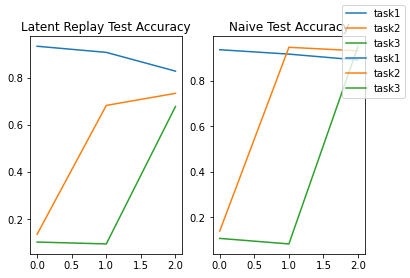

In [101]:
# JA: Next step - replace internal model.
# - model def ✅
# - frozen layer name ✅
# - batch renorm stuff...?

# JA: 2nd step
# - make GMM
# - add GMM to model sampler

results_ar1 = results
print(results_ar1)

['Top1_Acc_Epoch/train_phase/train_stream/Task000', 
 'Loss_Epoch/train_phase/train_stream/Task000',
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000',
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000',
 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001',
 'Loss_Exp/eval_phase/test_stream/Task001/Exp001',
 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002',
 'Loss_Exp/eval_phase/test_stream/Task002/Exp002',
 'Top1_Acc_Stream/eval_phase/test_stream/Task000',
 'Top1_Acc_Stream/eval_phase/test_stream/Task001',
 'Top1_Acc_Stream/eval_phase/test_stream/Task002',
 'Loss_Stream/eval_phase/test_stream/Task000',
 'Loss_Stream/eval_phase/test_stream/Task001',
 'Loss_Stream/eval_phase/test_stream/Task002',
 'Top1_Acc_Epoch/train_phase/train_stream/Task001',
 'Loss_Epoch/train_phase/train_stream/Task001',
 'Top1_Acc_Epoch/train_phase/train_stream/Task002',
 'Loss_Epoch/train_phase/train_stream/Task002']

def plotplot(results):
    results_clean = {"train":{'acc':[], 'loss':[]}, "test":{'acc':[], 'loss':[]}}
    loss_prefix = 'Loss_Stream/eval_phase/test_stream/'
    acc_prefix = 'Top1_Acc_Stream/eval_phase/test_stream/'
    
    for result in results:
        results_clean["test"]['loss'].append([
            result[f'{loss_prefix}Task000'], 
            result[f'{loss_prefix}Task001'], 
            result[f'{loss_prefix}Task002']])
        
        results_clean["test"]['acc'].append([
            result[f'{acc_prefix}Task000'], 
            result[f'{acc_prefix}Task001'], 
            result[f'{acc_prefix}Task002']])
        
       # results_clean["train"]['loss'].append([
       #     result['Loss_Epoch/train_phase/train_stream/Task000'], 
       #     result['Loss_Epoch/train_phase/train_stream/Task001'], 
       #     result['Loss_Epoch/train_phase/train_stream/Task002']])
    
    return results_clean
        
results_ar1_clean = plotplot(results)
results_naive_clean = plotplot(results_naive)

fig, axes = plt.subplots(1,2)

axes[0].plot(results_ar1_clean["test"]['acc'], label=['task1','task2','task3'])
axes[0].set_title('Latent Replay Test Accuracy')
axes[1].plot(results_naive_clean["test"]['acc'], label=['task1','task2','task3'])
axes[1].set_title('Naive Test Accuracy')

fig.legend()


In [103]:
print(results_ar1_clean["test"]['acc'])

print(results_naive_clean["test"]['acc'])

[[0.9325, 0.1364, 0.1034], [0.9065, 0.6819, 0.0955], [0.8271, 0.7331, 0.6772]]
[[0.936, 0.1405, 0.1081], [0.9168, 0.9467, 0.0839], [0.8908, 0.9312, 0.9513]]
